# Dask start

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36241")

# Import

In [2]:
import sys
sys.path.insert(1, '..')

In [3]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from dask import compute
import pandas as pd
import cartopy.crs as ccrs
import xgcm
import xesmf as xe
from random import randrange
import os

# Load data

Choose cases

In [4]:
data=[dict() for i in range(6)]

In [5]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

In [6]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [9]:
data_slice = dict(t=slice(0,-1,3)) 

In [10]:
chunk_dict = {'x_c' : -1, 'y_c' : -1, 'x_r' : -1, 'y_r' : -1, 't' : 22, 'z_c' : 54, 'z_l' : 54}

In [11]:
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET'] 

In [12]:
%%time
for i in range(len(data)) :
    current_set = xr.open_dataset(f'{SCRATCH_BUCKET}/data'+str(i)+'.zarr', engine="zarr", storage_options={"anon": True}, chunks='auto')
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk(chunk_dict)
    data[i]['LR'] = current_set.persist()

CPU times: user 2.95 s, sys: 352 ms, total: 3.3 s
Wall time: 8.65 s


In [13]:
data[-1]['LR']

<xarray.Dataset>
Dimensions:          (y_c: 47, x_c: 40, t: 30, z_c: 107, x_r: 40, y_r: 47,
                      z_l: 107)
Coordinates: (12/30)
    area             (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e1f              (y_r, x_r) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e1t              (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e1u              (y_c, x_r) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e1v              (y_r, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    e2f              (y_r, x_r) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    ...               ...
  * x_c              (x_c) int64 1 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
  * x_r              (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 37.5 38.5 39.5 40.5
  * y_c              (y_c) int64 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47
  * y_r              (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 44.5 45.5 46.5 47.5
  * z_c              (z_c) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * z_l              (z_l) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
Data variables: (12/36)
    dX_p             (t, z_c, y_c, x_c) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_p_error       (t, z_c, y_c, x_c) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_rho_delta     (t, z_c, y_c, x_r) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_rho_model     (t, z_c, y_c, x_r) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_sigma0_delta  (t, z_c, y_c, x_r) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    dX_sigma0_model  (t, z_c, y_c, x_r) float64 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    ...               ...
    vosaline         (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    vosaline_sqr     (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    vosaline_var     (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    votemper         (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    votemper_sqr     (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>
    votemper_var     (t, z_c, y_c, x_c) float32 dask.array<chunksize=(22, 54, 47, 40), meta=np.ndarray>

In [25]:
45*40*90*6

972000

# Calculate some additional variables

In [14]:
metrics_LR = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('Z',): ['e3t', 'e3w'], # Z distances
    ('X', 'Y',): ['area'] }

In [15]:
for i in range(len(data)) :
    data[i]['LR_grid'] = xgcm.Grid(data[i]['LR'], metrics=metrics_LR, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r'},
                                'Z' : {'center' : 'z_c', 'left' : 'z_l'}})
    ds = data[i]['LR']
    grid = data[i]['LR_grid']
    ds['grad_p'] = np.sqrt(ds['dX_p']**2 + ds['dY_p']**2)
    ds['grad_p_error'] = np.sqrt(ds['dX_p_error']**2 + ds['dY_p_error']**2)
    ds['grad_p_error_alignment'] = ((ds['dX_p']*ds['dX_p_error'] + ds['dY_p']*ds['dY_p_error'])/(ds['grad_p']*ds['grad_p_error']))
    ds['relative_grad_p_error'] = (ds['grad_p_error']/ds['grad_p'])

    ds['grad_votemper'] = np.sqrt(grid.interp(ds['dX_votemper']**2, axis='X') + grid.interp(ds['dY_votemper']**2, axis='Y'))
    ds['grad_votemper_var'] = np.sqrt(grid.interp(ds['dX_votemper_var']**2, axis='X') + grid.interp(ds['dY_votemper_var']**2, axis='Y'))
    ds = ds.chunk(chunk_dict)

# Random profiles

Pick 20 random points in (t,x,y) tto make random vertical profiles

In [22]:
random_profiles = [dict({'t': randrange(len(data[-1]['LR'].t)-5), \
                         'x_c': randrange(len(data[-1]['LR'].x_c)-2), \
                         'y_c': randrange(len(data[-1]['LR'].y_c)-2)}) for i in range(20)]
for profile in random_profiles:
    profile['x_r'] = profile['x_c']
    profile['y_r'] = profile['y_c']

# Vertical profiles of variables

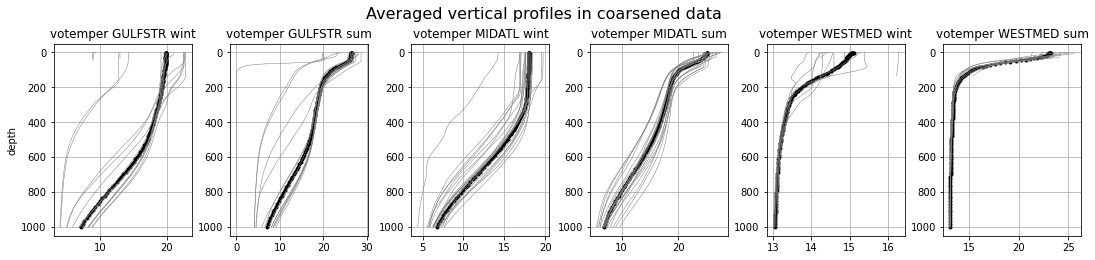

CPU times: user 3.72 s, sys: 372 ms, total: 4.09 s
Wall time: 5.96 s


In [23]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,3.5), squeeze=False, constrained_layout=True)
fig.suptitle('Averaged vertical profiles in coarsened data', fontsize=16)
for row, variable in enumerate(['votemper']) :
    for col in range(len(data)) :
        data[col]['LR'][variable].median(['x_c', 'y_c', 't']).plot(ax=ax[row,col], y='z_c', label=data[col]['label'], marker='.', color='k')
        for profile in random_profiles:
            data[col]['LR'][variable].isel(profile, missing_dims='ignore').plot(ax=ax[row,col], y='z_c', color='grey', ls='-', lw=0.5)
        ax[row,col].set(title=variable+' '+data[col]['label'], xlabel='', ylabel='', xscale='linear', yscale='linear')
        ax[row,col].grid(True)
        ax[row,col].invert_yaxis()
    ax[row,0].set(ylabel='depth')
plt.show()

In [50]:
X_data = data[3]['LR']['votemper'].fillna(0).values

In [51]:
n_time, n_z, n_x, n_y = X_data.shape

In [52]:
X_matrix = X_data.reshape((n_time, n_x, n_y, n_z)).reshape((n_time*n_x*n_y, n_z))
X_matrix.shape

(57600, 107)

In [53]:
from sklearn.decomposition import PCA

In [54]:
# ?PCA

In [60]:
n_components = 50
random_state = 123

clf = PCA(n_components=n_components, random_state=random_state)

clf.fit(X_matrix)

PCA(n_components=50, random_state=123)

In [61]:
Z_matrix = clf.transform(X_matrix)

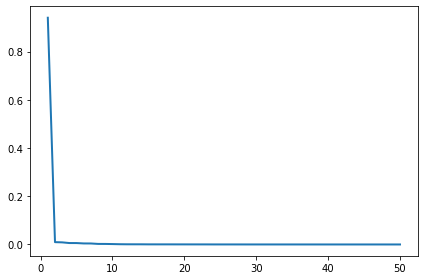

In [62]:
fig, ax = plt.subplots(nrows=1,)
ax.plot(
    np.arange(1, clf.n_components_ + 1), clf.explained_variance_ratio_,  linewidth=2
)

plt.tight_layout()
plt.show()

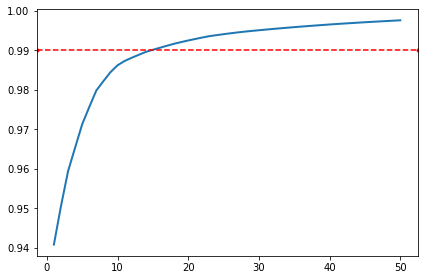

In [73]:
fig, ax = plt.subplots(nrows=1,)
ax.plot(
    np.arange(1, clf.n_components_ + 1), np.cumsum(clf.explained_variance_ratio_),  linewidth=2
)
ax.axhline(0.99, linestyle="--", marker=".", color="red")

plt.tight_layout()
plt.show()

In [65]:
X_data2 = data[2]['LR']['votemper'].fillna(0).values